# 1.1 Clusters with age below 500 Myrs

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

## Functions

In [3]:
def preprocess_cluster(data, g_mean_th=18):
    """
    ------
    parallax > 0 

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,6), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();
        
        
def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        );
    
    
def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(12,3), dpi=120)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data)
    
    plt.figure(figsize=(12,3), dpi=120)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt


def guassian_filter(data, column, mu, std):    
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)
    
    if up > low:
        print('upper bound:', up) 
        print('lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print('upper bound:', low) 
        print('lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]
    
    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """    
    
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');

## open cluster names

In [4]:
open_clusters = pd.read_excel('../../data/open clusters table.xlsx')

open_clusters = open_clusters.dropna(axis=0, subset=['Name', 'logt']).drop(index=0)
open_clusters['logt'] = open_clusters.logt.astype(float)

x = open_clusters[(10**open_clusters['logt'] < 2 * 10**9) & (10**open_clusters['logt'] >= 1 * 10**9)].index
open_clusters.loc[x].dropna(axis=1).head(60)

,Name,RA,DEC,l,b,d,logt,D
65,ASCC 48,08 34 29,-37 36 36,257.39,1.61,400,9.090,38.4
109,ASCC 92,17 51 07,-11 52 48,15.35,7.63,650,9.010,36
173,Berkeley 14,05 00 12,+43 28 00,162.87,0.71,5500,9.200,5
180,Berkeley 22,05 58 24,+07 50 00,199.88,-8.08,7663,9.027,1
183,Berkeley 27,06 51 18,+05 46 00,207.78,2.6,5035,9.300,2
185,Berkeley 29,06 53 18,+16 55 00,197.98,8.02,14871,9.025,6
196,Berkeley 57,22 55 08,+57 05 54,107.61,-2.27,4150,9.150,5
201,Berkeley 64,02 21 06,+65 54 00,131.92,4.61,3981,9.000,2
204,Berkeley 67,04 38 06,+50 45 00,154.88,2.5,2450,9.000,10
213,Berkeley 81,19 01 36,+00 31 00,34.51,-2.07,3000,9.000,5


--------

In [5]:
df_NGC_2281 = pd.read_csv('../../data/NGC 2281-result.csv')
df_NGC_2866 = pd.read_csv('../../data/NGC 2866-result.csv')
df_NGC_3590 = pd.read_csv('../../data/NGC 3590-result.csv')

In [6]:
df_NGC_2281 = preprocess_cluster(df_NGC_2281, g_mean_th=18)
df_NGC_2866 = preprocess_cluster(df_NGC_2866, g_mean_th=19)
df_NGC_3590 = preprocess_cluster(df_NGC_3590, g_mean_th=18)

6361
888
2004


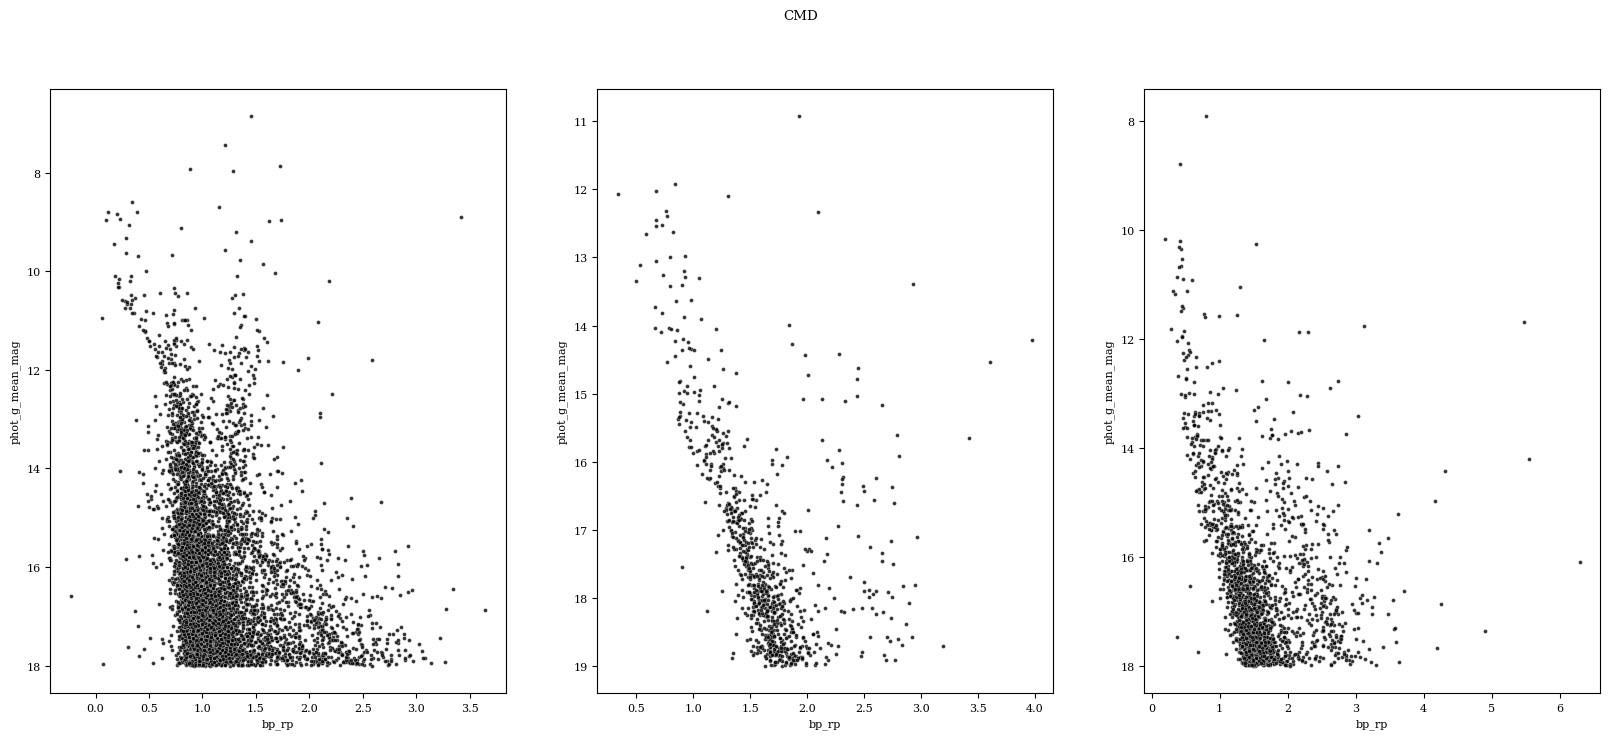

In [7]:
def cmd_plotly(data, x_axis, y_axis, ax=None, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """
    if ax is None:
        fig = plt.figure(figsize=(6,6), dpi=100)
        ax = fig.add_subplot(111)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax)
    ax.invert_yaxis()
        
with plt.style.context(['ieee']):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), dpi=100)
    fig.suptitle('CMD')
    cmd_plotly(df_NGC_2281, 'bp_rp', 'phot_g_mean_mag', alpha=0.8, s=8, ax=ax1)
    cmd_plotly(df_NGC_2866, 'bp_rp', 'phot_g_mean_mag', alpha=0.8, s=8, ax=ax2)
    cmd_plotly(df_NGC_3590, 'bp_rp', 'phot_g_mean_mag', alpha=0.8, s=8, ax=ax3)

In [8]:
df_NGC_2281_new = df_NGC_2281.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)

df_NGC_2866_new = df_NGC_2866.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)

df_NGC_3590_new = df_NGC_3590.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)

print(len(df_NGC_2281_new))
print(len(df_NGC_2866_new))
print(len(df_NGC_3590_new))

6322
867
1952


## NGC_2281 (360 Myr)

<Figure size 540x360 with 0 Axes>

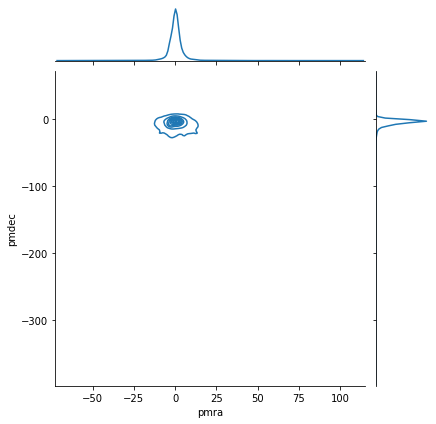

In [42]:
joint_plot(df_NGC_2281_new);

In [108]:
# Initial Filter on PMRA and PMDEC based on joint plot

df_NGC_2281_new = df_NGC_2281_new[abs(df_NGC_2281_new['pmra']) < 20]
df_NGC_2281_new = df_NGC_2281_new[abs(df_NGC_2281_new['pmdec']) < 20]
len(df_NGC_2281_new)

6073

<Figure size 540x360 with 0 Axes>

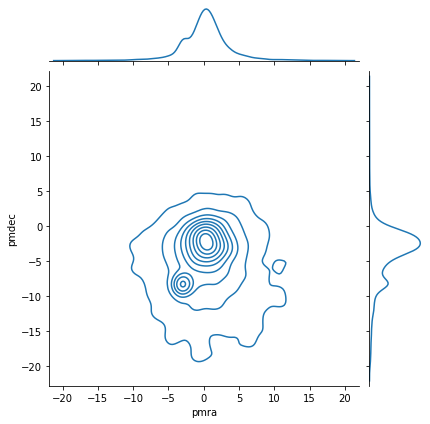

In [45]:
joint_plot(df_NGC_2281_new);

----

# 2 

## 2.1 Filters

**NGC 2281:**  

Proper motions mas/yr based on [SIMBAD](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=NGC+2281&submit=SIMBAD+search):	
```python
    pmra:  -2.946  
    pmdec: -8.321
```

In [122]:
df_NGC_2281_new = df_NGC_2281_new[abs(df_NGC_2281_new['pmra'] +2.95) < 2]
len(df_NGC_2281_new)

1512

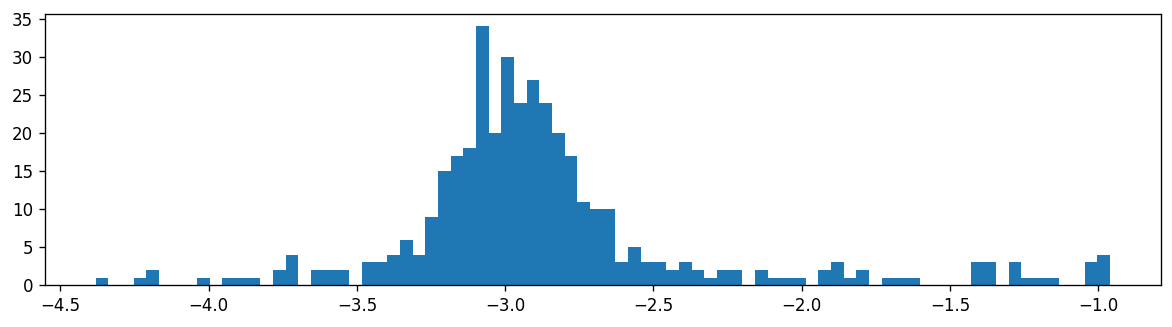

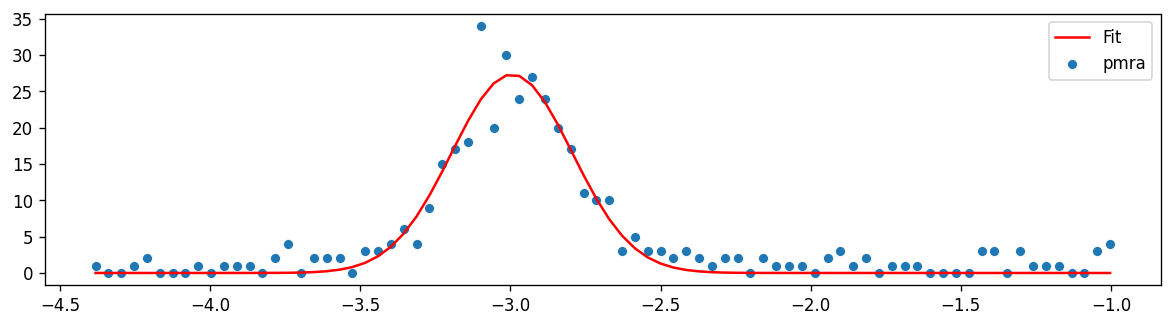

In [129]:
amp, mu, std = fit_curve(df_NGC_2281_new, 'pmra', bins=80)

In [130]:
df_NGC_2281_new = guassian_filter(df_NGC_2281_new, 'pmra', mu, std)

upper bound: -2.39
lower bound: -3.6
cluster length: 325


In [125]:
df_NGC_2281_new = df_NGC_2281_new[abs(df_NGC_2281_new['pmdec'] +8.3) < 3]
len(df_NGC_2281_new)

577

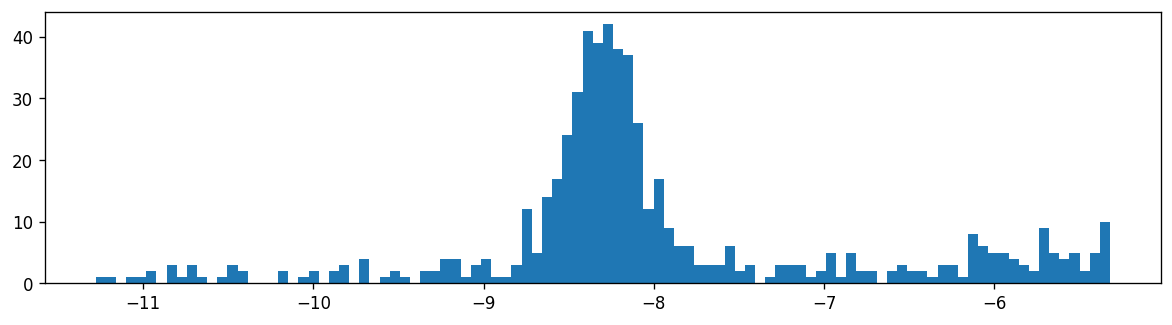

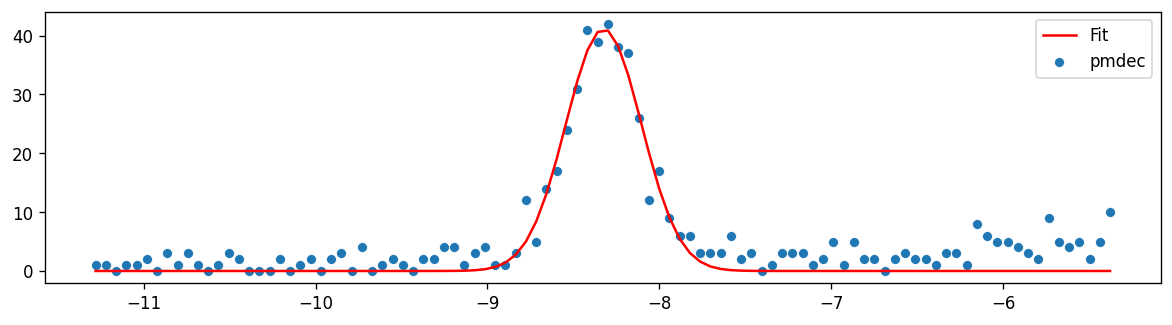

In [126]:
amp, mu, std = fit_curve(df_NGC_2281_new, 'pmdec', bins=100)

In [127]:
df_NGC_2281_new = guassian_filter(df_NGC_2281_new, 'pmdec', mu, std)

upper bound: -7.66
lower bound: -8.98
cluster length: 387


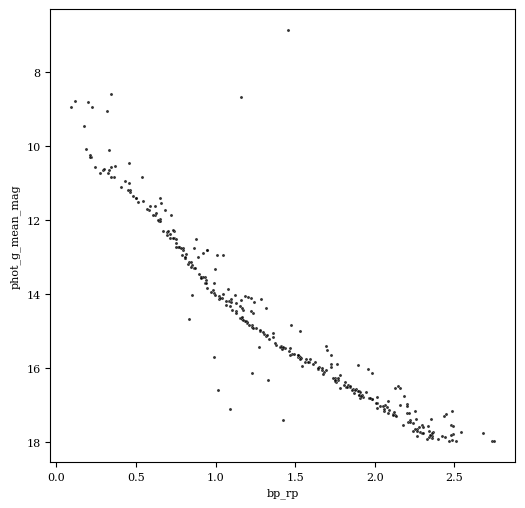

In [131]:
cmd_plot(df_NGC_2281_new, 'bp_rp', 'phot_g_mean_mag')

## 2.1 GMM

In [142]:
gm = GaussianMixture(n_components=2, random_state=101)

y_pred = gm.fit_predict(df_NGC_2281_new[['pmra', 'pmdec', 'parallax']])
y_prob = gm.predict_proba(df_NGC_2281_new[['pmra', 'pmdec', 'parallax']])
df_NGC_2281_new['cluster'] = y_pred
df_NGC_2281_new['prob'] = np.amax(y_prob,axis=1)

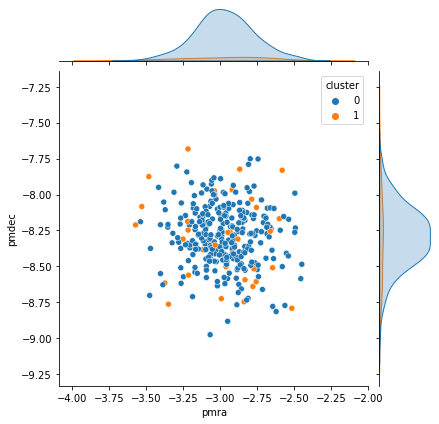

In [143]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_2281_new, kind='scatter', hue='cluster');

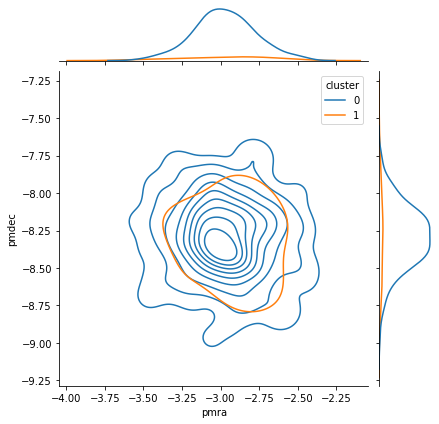

In [144]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_2281_new, kind='kde', hue='cluster');

# 3 

## CMD plot and g_rp:bp_rp

In [148]:
cluster_NGC_2281 = df_NGC_2281_new[df_NGC_2281_new['cluster']==0]
len(cluster_NGC_2281)

291

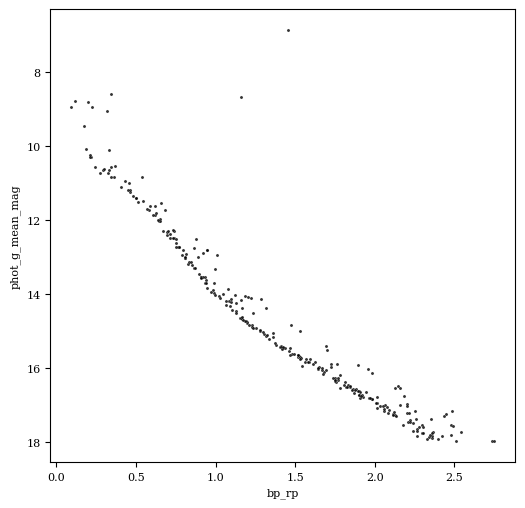

In [150]:
cmd_plot(cluster_NGC_2281, 'bp_rp', 'phot_g_mean_mag')

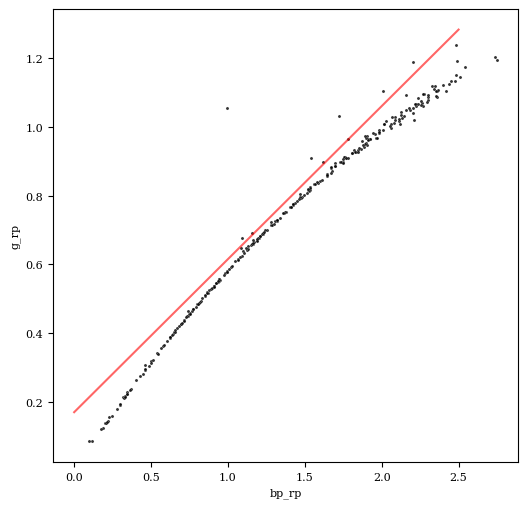

In [157]:
cmd_plot(cluster_NGC_2281, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0., 2.5), 0.445 * np.linspace(0., 2.5) + 0.17, alpha=0.6, color='red')
plt.gca().invert_yaxis();

<AxesSubplot:xlabel='ra', ylabel='dec'>

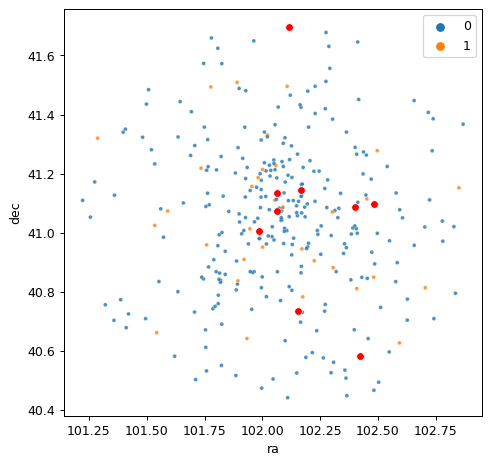

In [158]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = df_NGC_2281_new, x = 'ra', y='dec', alpha=0.8, s=10, hue='cluster')

sns.scatterplot(data = cluster_NGC_2281[ (( cluster_NGC_2281['bp_rp'] * 0.445) + 0.17 ) < cluster_NGC_2281['g_rp'] ],
                x = 'ra', y = 'dec', color = 'red')

### Number of stars out black body diagram

In [159]:
len(cluster_NGC_2281[ (( cluster_NGC_2281['bp_rp'] * 0.445) + 0.17 ) < cluster_NGC_2281['g_rp'] ])

9

--------------
-------------
--------------
-------------


# NGC_2866 (45 Myr)

<Figure size 540x360 with 0 Axes>

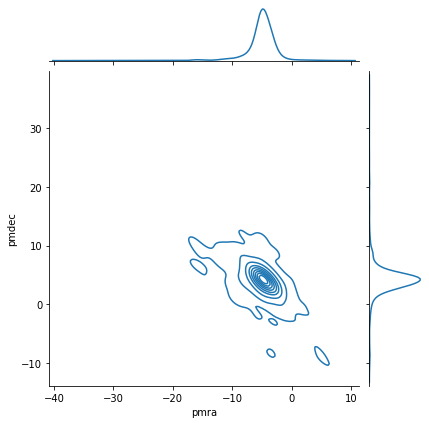

In [160]:
joint_plot(df_NGC_2866_new);

In [180]:
# Initial Filter on PMRA and PMDEC based on joint plot

df_NGC_2866_new = df_NGC_2866_new[abs(df_NGC_2866_new['pmra']) < 20]
df_NGC_2866_new = df_NGC_2866_new[abs(df_NGC_2866_new['pmdec']) < 20]
len(df_NGC_2866_new)

858

<Figure size 540x360 with 0 Axes>

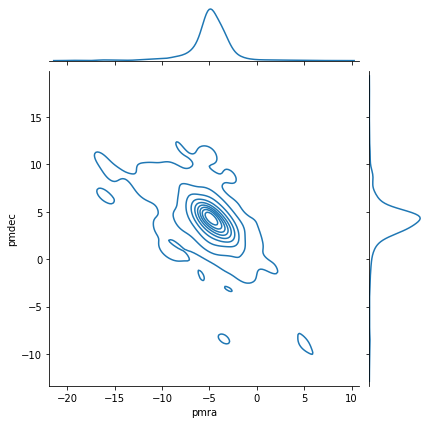

In [163]:
joint_plot(df_NGC_2866_new);

-----

# 2 

## 2.1 Filters

**NGC 2866:**

Proper motions mas/yr based on [SIMBAD](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=NGC+2866%09&submit=SIMBAD+search):
```py
    pmra:  -5.111  
    pmdec:  4.658 
    
```

In [197]:
df_NGC_2866_new = df_NGC_2866_new[abs(df_NGC_2866_new['pmra'] + 5.1) < 1.25]
len(df_NGC_2866_new)

520

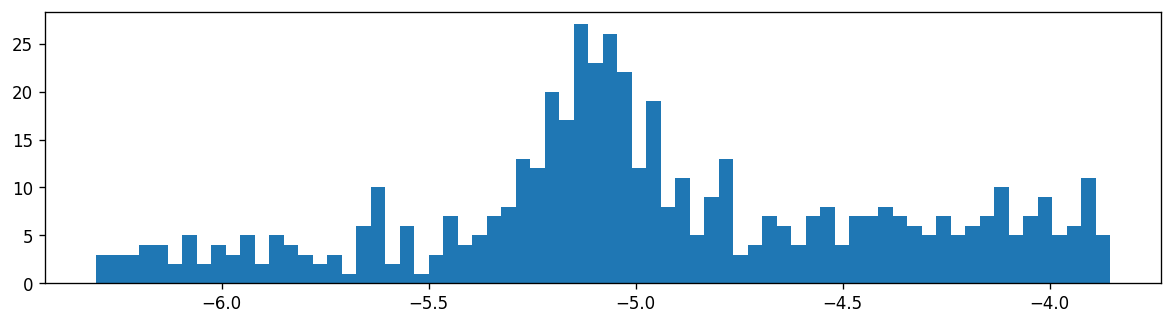

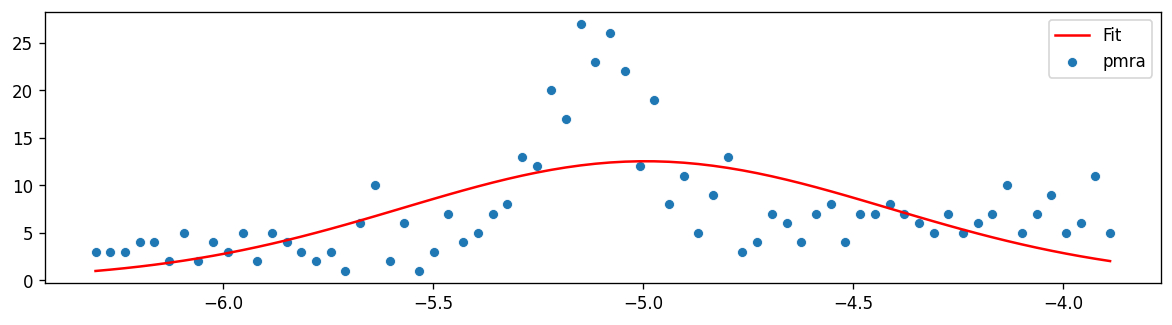

In [198]:
amp, mu, std = fit_curve(df_NGC_2866_new, 'pmra', bins=70)

In [199]:
df_NGC_2866_new = guassian_filter(df_NGC_2866_new, 'pmra', mu, std)

upper bound: -3.26
lower bound: -6.73
cluster length: 520


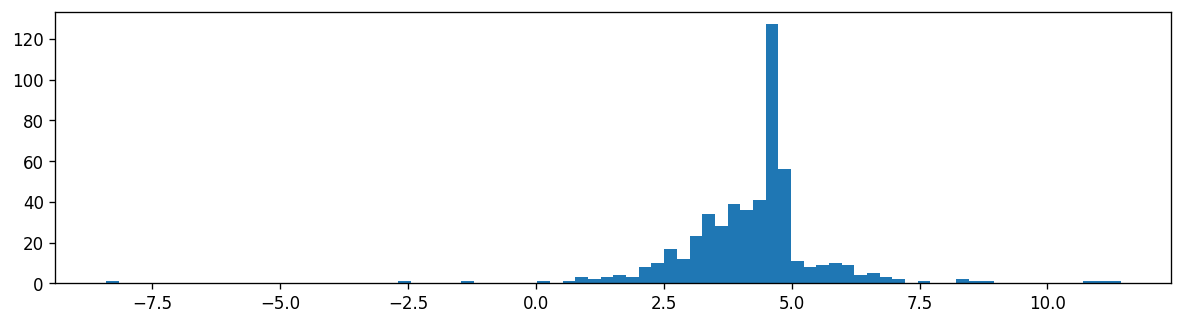

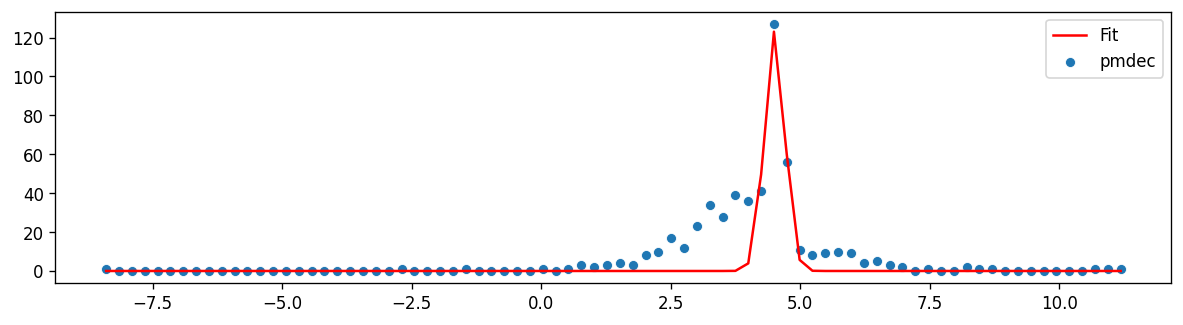

In [200]:
amp, mu, std = fit_curve(df_NGC_2866_new, 'pmdec', bins=80)

In [201]:
df_NGC_2866_new = guassian_filter(df_NGC_2866_new, 'pmdec', mu, std)

upper bound: 5.09
lower bound: 3.92
cluster length: 279


-----

## 2.2 GMM

In [223]:
gm = GaussianMixture(n_components=2, random_state=101)

y_pred = gm.fit_predict(df_NGC_2866_new[['pmra', 'pmdec', 'parallax']])
y_prob = gm.predict_proba(df_NGC_2866_new[['pmra', 'pmdec','parallax']])
df_NGC_2866_new['cluster'] = y_pred
df_NGC_2866_new['prob'] = np.amax(y_prob,axis=1)

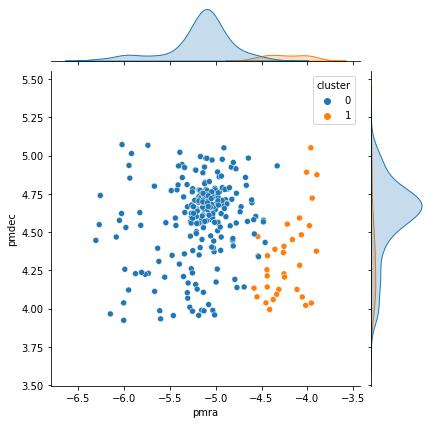

In [224]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_2866_new, kind='scatter', hue='cluster');

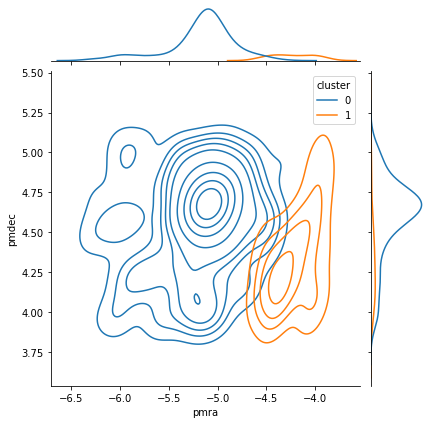

In [225]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_2866_new, kind='kde', hue='cluster');

----------
----------

# 3 
##  CMD plot and g_rp:bp_rp

In [226]:
cluster_NGC_2866 = df_NGC_2866_new[df_NGC_2866_new['cluster'] == 0]
len(cluster_NGC_2866)

246

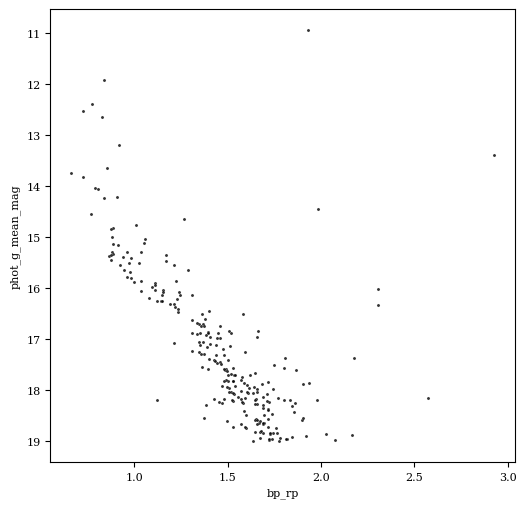

In [227]:
cmd_plot(cluster_NGC_2866, 'bp_rp', 'phot_g_mean_mag')

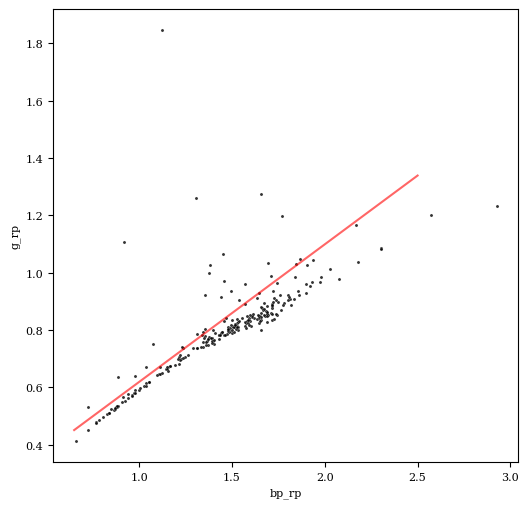

In [234]:
cmd_plot(cluster_NGC_2866, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0.65, 2.5), 0.48 * np.linspace(0.65,2.5) + 0.139, alpha=0.6, color='red')
plt.gca().invert_yaxis();

<font color='red'>Nemudar ajibe!!!</font>

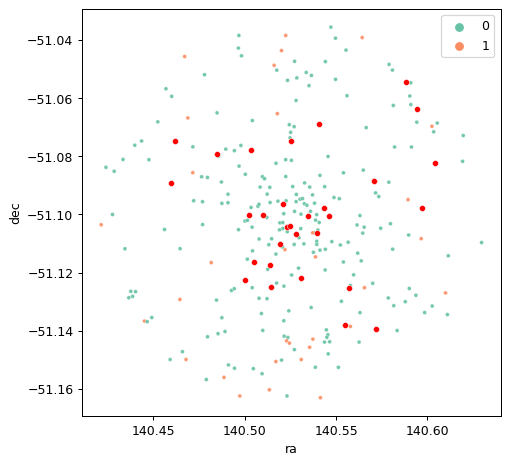

In [235]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = df_NGC_2866_new, x = 'ra', y='dec', alpha=0.9, s=10, hue='cluster', palette='Set2')

sns.scatterplot(data = cluster_NGC_2866[((cluster_NGC_2866['bp_rp']*0.48) +0.139) < cluster_NGC_2866['g_rp']],
                s=23, x = 'ra', y = 'dec', color = 'red');

### Number of stars out black body diagram

In [236]:
len(cluster_NGC_2866[((cluster_NGC_2866['bp_rp']*0.48) +0.139) < cluster_NGC_2866['g_rp']])

30

-------------
-------------
-------------
-------------


# NGC_3590 (17 Myr)

<Figure size 540x360 with 0 Axes>

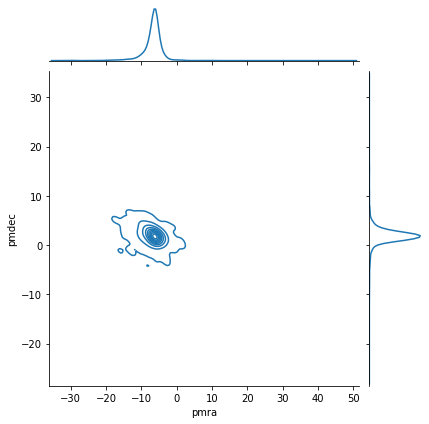

In [72]:
joint_plot(df_NGC_3590_new)

In [9]:
# Initial Filter on PMRA and PMDEC based on joint plot
df_NGC_3590_new = df_NGC_3590_new[abs(df_NGC_3590_new['pmra']) < 20]
df_NGC_3590_new = df_NGC_3590_new[abs(df_NGC_3590_new['pmdec']) < 20]
len(df_NGC_3590_new)

1936

<Figure size 540x360 with 0 Axes>

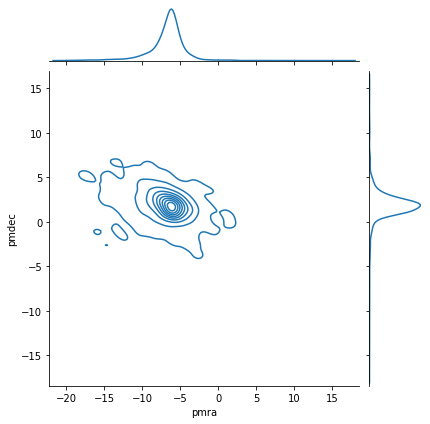

In [240]:
joint_plot(df_NGC_3590_new)

----

# 2 

## 2.1 Filters

Berkeley 58:

Proper motions mas/yr based on [SIMBAD](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=NGC+3590&submit=SIMBAD+search):
```py
    pmra:  -6.100 
    pmdec:  1.013 
```

In [28]:
df_NGC_3590_new = df_NGC_3590_new[abs(df_NGC_3590_new['pmra'] + 6.1) < 1]
len(df_NGC_3590_new)

274

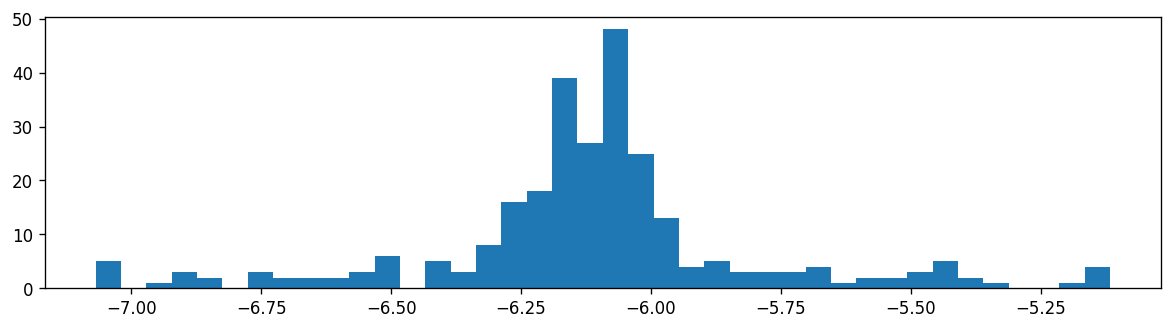

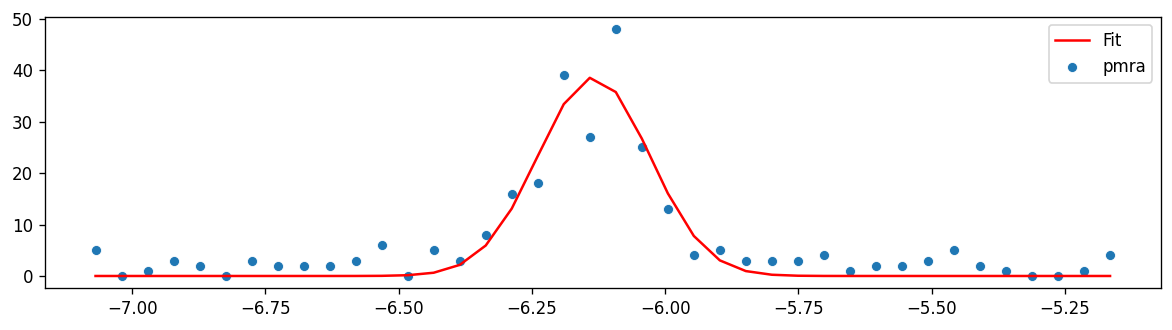

In [29]:
amp, mu, std = fit_curve(df_NGC_3590_new, 'pmra', bins=40)

In [30]:
df_NGC_3590_new = guassian_filter(df_NGC_3590_new, 'pmra', mu, std)

upper bound: -5.82
lower bound: -6.45
cluster length: 213


In [31]:
df_NGC_3590_new = df_NGC_3590_new[abs(df_NGC_3590_new['pmdec'] - 1.01) < 0.5]
len(df_NGC_3590_new)

213

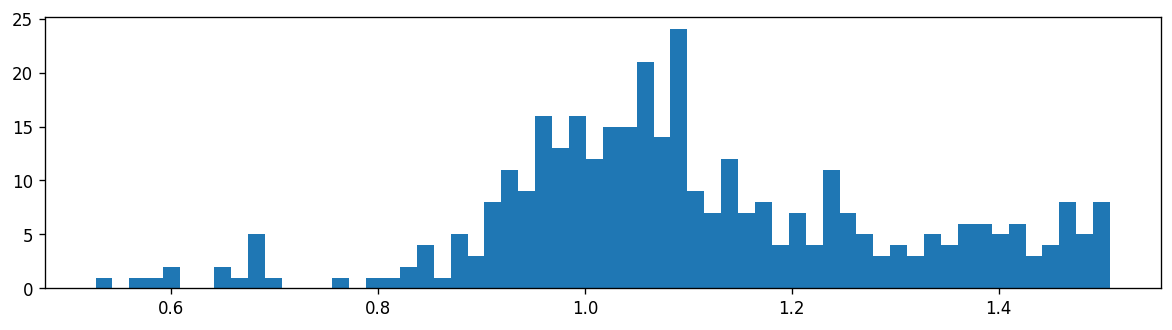

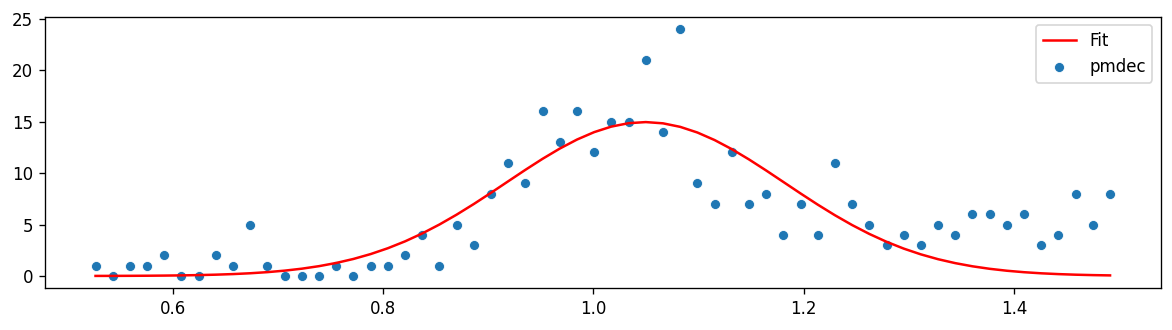

In [14]:
amp, mu, std = fit_curve(df_NGC_3590_new, 'pmdec', bins=60)

In [15]:
df_NGC_3590_new = guassian_filter(df_NGC_3590_new, 'pmdec', mu, std)

upper bound: 1.45
lower bound: 0.65
cluster length: 326


In [16]:
df_NGC_3590_new = df_NGC_3590_new[abs(df_NGC_3590_new['parallax'] - 0.36) < 1]
len(df_NGC_3590_new)

326

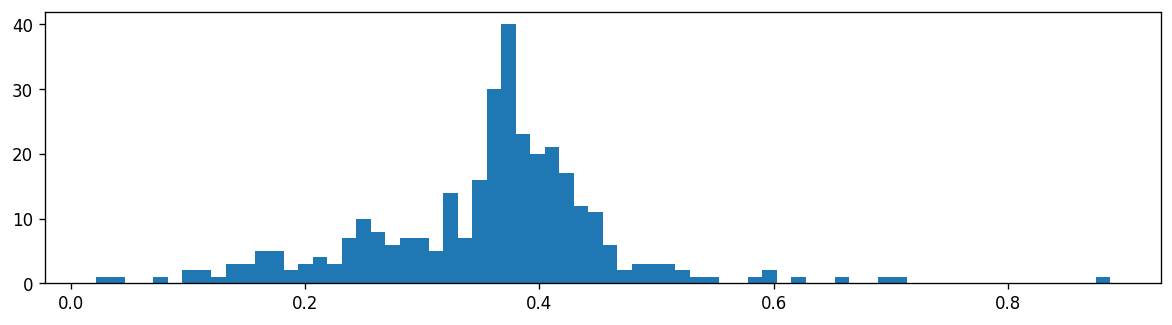

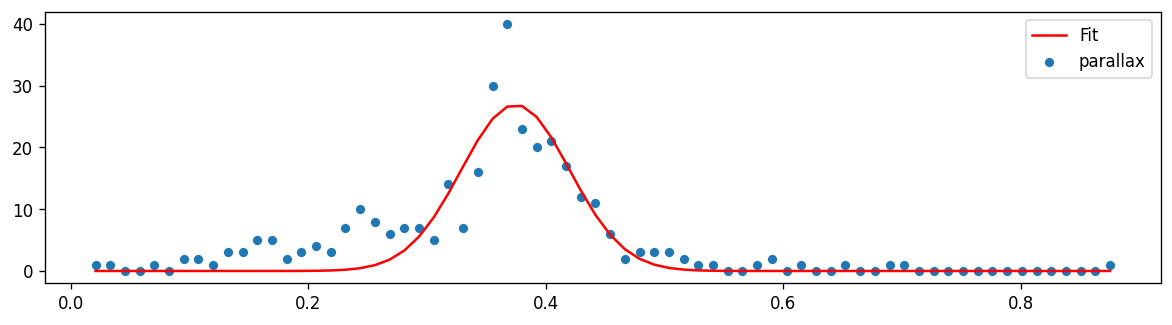

In [17]:
amp, mu, std = fit_curve(df_NGC_3590_new, 'parallax', bins=70)

In [18]:
df_NGC_3590_new = guassian_filter(df_NGC_3590_new, 'parallax', mu, std)

upper bound: 0.51
lower bound: 0.24
cluster length: 274


## 2.2 GMM

In [32]:
gm = GaussianMixture(n_components=2, random_state=101)

y_pred = gm.fit_predict(df_NGC_3590_new[['pmra', 'pmdec', 'parallax']])
y_prob = gm.predict_proba(df_NGC_3590_new[['pmra', 'pmdec', 'parallax']])
df_NGC_3590_new['cluster'] = y_pred
df_NGC_3590_new['prob'] = np.amax(y_prob,axis=1)

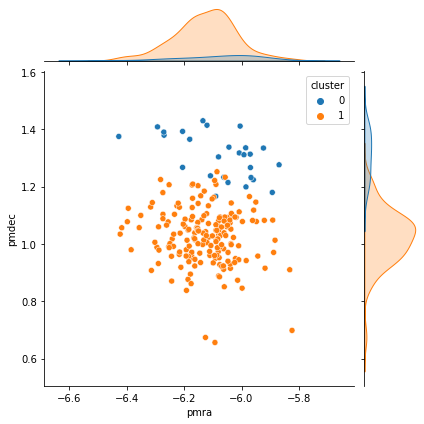

In [33]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_3590_new, kind='scatter', hue='cluster');

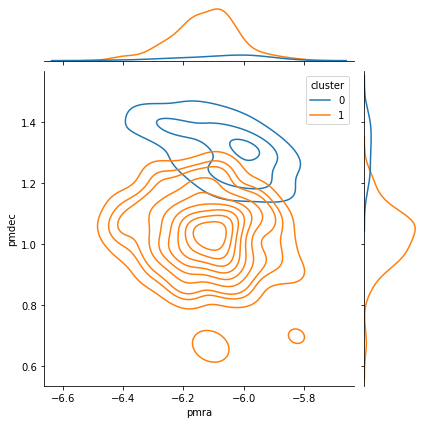

In [34]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_3590_new, kind='kde', hue='cluster');

----

# 3 

## CMD plot and g_rp:bp_rp

In [35]:
cluster_NGC_3590 = df_NGC_3590_new[df_NGC_3590_new['cluster']==1]
len(cluster_NGC_3590)

186

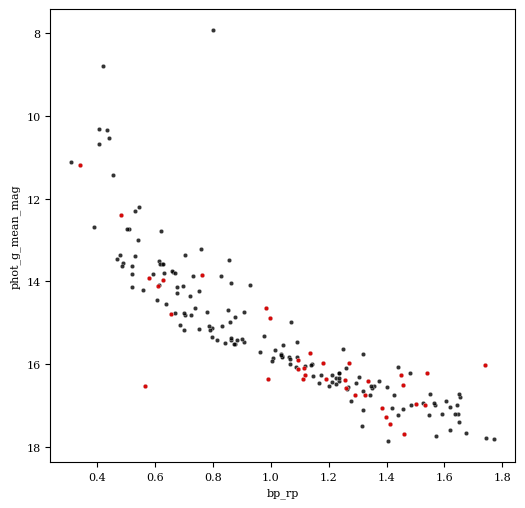

In [41]:
with plt.style.context(['ieee']):
    fig = plt.figure(figsize=(6,6), dpi=100)
    sns.scatterplot(data=cluster_NGC_3590, y='phot_g_mean_mag', x='bp_rp', alpha=0.8, s=10)
    sns.scatterplot(data=cluster_NGC_3590[ (( cluster_NGC_3590['bp_rp'] * 0.49) + 0.123 ) < cluster_NGC_3590['g_rp'] ],
                    y='phot_g_mean_mag', x='bp_rp', alpha=0.8, s=10, color= 'red')
    plt.gca().invert_yaxis();

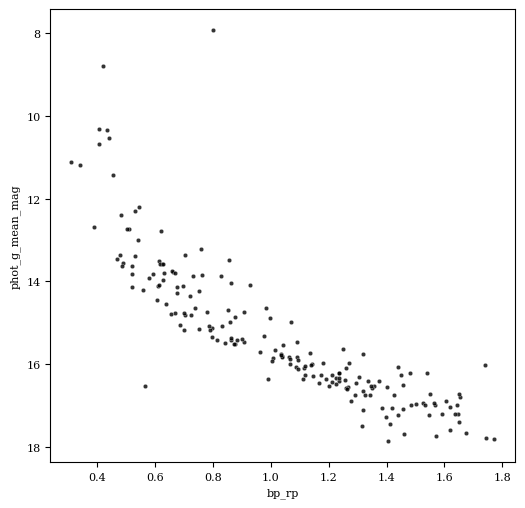

In [42]:
cmd_plot(cluster_NGC_3590, 'bp_rp', 'phot_g_mean_mag', s=10)

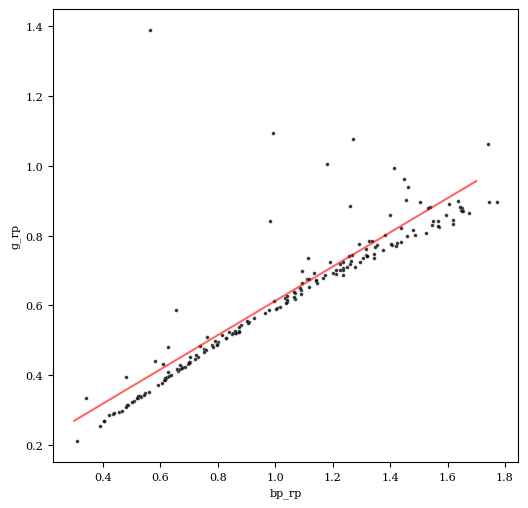

In [37]:
cmd_plot(cluster_NGC_3590, 'bp_rp', 'g_rp', s=7)
plt.plot(np.linspace(0.3, 1.7), 0.49 * np.linspace(0.3, 1.7) + 0.123, alpha=0.6, color='red')
plt.gca().invert_yaxis();

<AxesSubplot:xlabel='ra', ylabel='dec'>

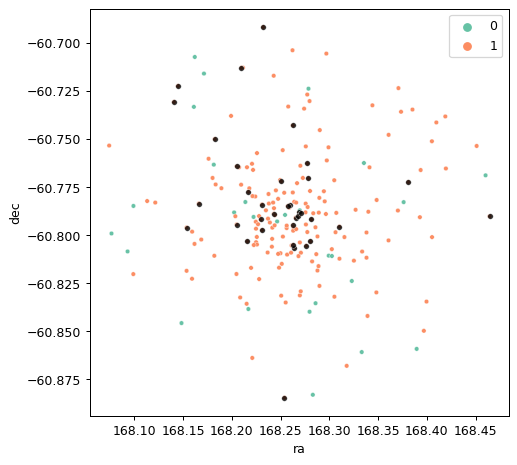

In [38]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = df_NGC_3590_new, x = 'ra', y='dec', alpha=0.99, s=13, hue='cluster', palette='Set2')

sns.scatterplot(data = cluster_NGC_3590[ (( cluster_NGC_3590['bp_rp'] * 0.49) + 0.123 ) < cluster_NGC_3590['g_rp'] ],
                s=20, alpha=0.8, x = 'ra', y = 'dec', color = 'black')

### Number of stars out black body diagram

In [39]:
len(cluster_NGC_3590[((cluster_NGC_3590['bp_rp']*0.49)+0.123)<cluster_NGC_3590['g_rp']])

35

In [40]:
cluster_NGC_3590[cluster_NGC_3590['g_rp'] > 1.2]

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,g_rp,r_med_geo,r_med_photogeo,Gmg,L,cluster,prob
11515,168.209836,-60.712982,0.477487,-6.287264,0.978447,16.530983,0.563568,1.389537,2079.0754,2355.2412,4.925791,0.915553,1,0.999985


Hard to detect this OUTLIER! ☝☝

<AxesSubplot:xlabel='bp_rp', ylabel='L'>

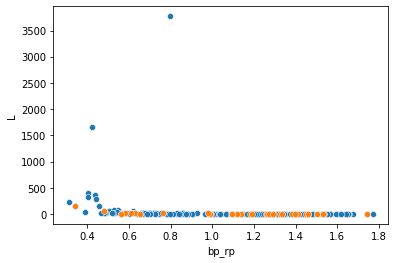

In [49]:
sns.scatterplot(data=cluster_NGC_3590, x='bp_rp', y='L')
sns.scatterplot(data=cluster_NGC_3590[((cluster_NGC_3590['bp_rp']*0.49)+0.123)<cluster_NGC_3590['g_rp']],
                x='bp_rp', y='L')
# plt.ylim(0, 500);

In [44]:
cluster_NGC_3590[((cluster_NGC_3590['bp_rp']*0.49)+0.123)<cluster_NGC_3590['g_rp']]

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,g_rp,r_med_geo,r_med_photogeo,Gmg,L,cluster,prob
2342,168.464379,-60.790160,0.359743,-6.018608,1.093013,15.739423,1.136063,0.692712,2563.3662,2494.1410,3.519387,3.343836,1,0.968112
2740,168.380996,-60.772406,0.402214,-6.088882,1.207734,14.877874,0.996016,0.611472,2290.4382,2267.2896,2.900158,5.914756,1,0.696281
3413,168.253955,-60.884546,0.257397,-6.074871,1.094095,16.031246,1.741668,1.061252,3592.8616,3420.9100,3.084264,4.992226,1,0.883127
4706,168.264191,-60.806565,0.377134,-6.288729,1.059677,17.063887,1.383711,0.803053,2630.2954,2587.9407,4.946365,0.898367,1,0.999816
4770,168.262551,-60.805136,0.318256,-5.918099,0.915337,16.379131,1.257948,0.741203,3041.4167,2808.1875,3.893014,2.370251,1,0.999808
4786,168.265495,-60.790939,0.508238,-6.082570,1.046961,17.443396,1.412079,0.994764,1968.8280,1934.7416,5.973730,0.348745,1,0.994385
4835,168.276190,-60.805544,0.443746,-6.141897,1.167973,16.736780,1.327214,0.784955,2162.5342,2169.2190,4.972451,0.877040,1,0.953035
4843,168.262611,-60.794798,0.296018,-6.135067,0.997924,16.104155,1.113339,0.735909,3169.8923,3065.7751,3.460747,3.529402,1,0.999810
4851,168.280533,-60.803222,0.380992,-6.181592,0.946797,16.509117,1.455607,0.902693,2507.3386,2453.4553,4.413695,1.467311,1,0.999995
5088,168.215784,-60.803206,0.426646,-6.009983,0.993431,16.214043,1.538818,0.881891,2307.7280,2113.0278,4.364383,1.535489,1,0.998996
